# Figure 3 & 4: PCA Saliency Map

## 1. Imports

In [1]:
from pathlib import Path
import json
import numpy as np
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

from fours.utils.data_handling import read_fours_root_dir, load_adi_data

## 2. Load the dataset

In [2]:
dataset_name = "HD22049_351_096_C-0679_A_"
root_dir = Path(read_fours_root_dir())
json_file = root_dir / Path("30_data/" + dataset_name + ".json")

Data in the FOURS_ROOT_DIR found. Location: /fast/mbonse/s4


In [3]:
with open(json_file) as f:
    parameter_config = json.load(f)

dit_psf_template = float(parameter_config["dit_psf"])
dit_science = float(parameter_config["dit_science"])
fwhm = float(parameter_config["fwhm"])
scaling_factor = float(parameter_config["nd_scaling"])
lambda_reg = float(parameter_config["lambda_reg"])
svd_approx = int(parameter_config["svd_approx"])
pixel_scale=0.02718

In [4]:
dataset_file = root_dir / Path("30_data/" + dataset_name + ".hdf5")
experiment_root_dir = root_dir / Path("70_results/x1_fake_planet_experiments/" + dataset_name)
experiment_root_dir.mkdir(exist_ok=True)

In [5]:
science_data, angles, raw_psf_template_data = load_adi_data(
    dataset_file,
    data_tag="object_stacked_05",
    psf_template_tag="psf_template",
    para_tag="header_object_stacked_05/PARANG")

psf_template = np.median(raw_psf_template_data, axis=0)

In [6]:
# we cut the image to 91 x 91 pixel to be slightly larger than 1.2 arcsec
cut_off = int((science_data.shape[1] - 91) / 2)
science_data = science_data[:, cut_off:-cut_off, cut_off:-cut_off]

## 3. Bild PCA basis

In [7]:
# 1.) Convert images to torch tensor
im_shape = science_data.shape
images_torch = torch.from_numpy(science_data)

# 2.) remove the mean as needed for PCA
images_torch = images_torch - images_torch.mean(dim=0)

# 3.) reshape images to fit for PCA
images_torch = images_torch.view(im_shape[0], im_shape[1] * im_shape[2])

# 4.) compute PCA basis
_, _, V = torch.svd_lowrank(images_torch, niter=1, q=1000)

In [8]:
pca_number = 300

In [9]:
# 5.) compute input gradients
input_gradients = torch.matmul(V[:, :pca_number], V[:, :pca_number].T)
input_gradients = np.abs(input_gradients.detach().numpy())
input_gradients = input_gradients.reshape(-1, 91, 91)

In [10]:
# 6.) compute input gradients for different pca components
input_gradients_dict = dict()

for tmp_pca_number in [10, 100, 300]:
    tmp_input_gradients = torch.matmul(V[:, :tmp_pca_number], V[:, :tmp_pca_number].T)
    tmp_input_gradients = np.abs(tmp_input_gradients.detach().numpy())
    tmp_input_gradients = tmp_input_gradients.reshape(-1, 91, 91)
    
    input_gradients_dict[tmp_pca_number] = tmp_input_gradients

## 4. Get an example image and projection

In [11]:
from matplotlib.colors import LogNorm, SymLogNorm

In [12]:
pca_rep = torch.matmul(images_torch, V[:, :pca_number])
noise_estimate = torch.matmul(pca_rep, V[:, :pca_number].T)

idx = 300
example_image = images_torch[idx].reshape(91, 91).numpy()
noise_estiamte = noise_estimate[idx].reshape(91, 91).numpy()

In [13]:
example_image = np.log(example_image - np.min(example_image)*1.1)
noise_estiamte = np.log(noise_estiamte - np.min(noise_estiamte)*1.1)

## 5. Create the First Plot

In [14]:
colors = ["dimgray", "aqua", "darkorange", "crimson"]

In [15]:
def plot_saliency_map(
    axis_in,
    input_gradients,
    position):
    
    idx = position[0] * 91 + position[1]
    axis_in.imshow(input_gradients[idx])
    axis_in.axis("off")
    
    axis_in.scatter(45, 45, color="red", marker="*", s=50)

In [16]:
def add_marker_circle(axis_in, position, color, size=80, lw=1):
    # add a circle around the position
    axis_in.scatter(position[1], position[0], 
                    edgecolors=color,
                    facecolors='none',
                    alpha=0.5,
                    marker="o",
                    lw=lw,
                    s=size)

In [17]:
position1 = (55, 37)
position2 = (70, 30)
idx1 = position1[0] * 91 + position1[1]
idx2 = position2[0] * 91 + position2[1]

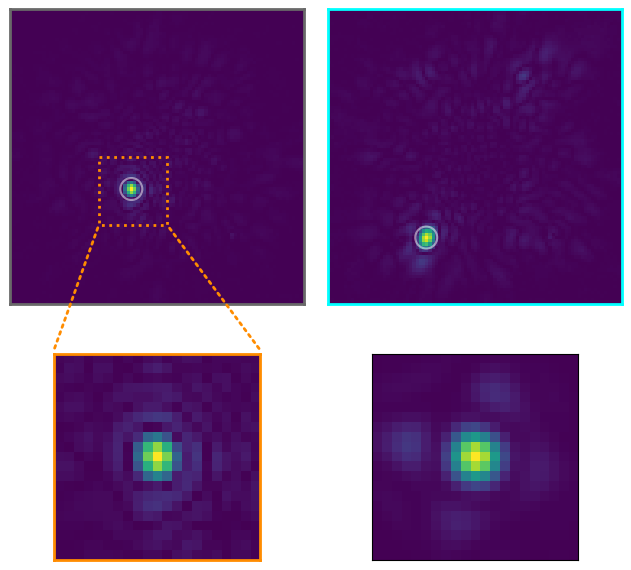

In [18]:
# --------------------------------------------------------------------
# 1.) Create Plot Layout
fig = plt.figure(constrained_layout=False, figsize=(8, 7.15))
gs01 = fig.add_gridspec(
    2, 2, 
    wspace=0.05, hspace=0.2,
    height_ratios = [1, 0.7])

ax_example_1 = fig.add_subplot(gs01[0, 0])
ax_example_2 = fig.add_subplot(gs01[0, 1])
ax_zoom_in = fig.add_subplot(gs01[1, 0])
ax_psf = fig.add_subplot(gs01[1, 1])

# --------------------------------------------------------------------
# 3.) Plot the Saliency Maps
ax_example_1.imshow(input_gradients[idx1])
ax_example_1.set_xticks([])
ax_example_1.set_yticks([])
ax_example_2.imshow(input_gradients[idx2])
ax_example_2.set_xticks([])
ax_example_2.set_yticks([])

plt.setp(ax_example_2.spines.values(), 
         color=colors[1], 
         linewidth=2, 
         linestyle="-")

plt.setp(ax_example_1.spines.values(), 
         color=colors[0], 
         linewidth=2, 
         linestyle="-")

add_marker_circle(ax_example_1, position1, "white", 250, 1.5)
add_marker_circle(ax_example_2, position2, "white", 250, 1.5)

# Zoomed in Version ---------------------
ax_example_1.add_patch(Rectangle(
    [position1[1]-10,
     position1[0]-10], 
    21, 21, 
    fill=False, 
    edgecolor=colors[2], 
    lw=2, ls="dotted"))

arrowKwargs = {
        'arrowstyle' : '-',
        'linestyle' : 'dotted',
        'color': colors[2],
        'linewidth':2}

ax_example_1.annotate(
    '', 
    xy=[position1[1]-10,
        position1[0]+11], 
    xytext=[13, 105], 
    arrowprops=arrowKwargs)

ax_example_1.annotate(
    '', 
    xy=[position1[1]+11,
        position1[0]+11], 
    xytext=[77, 105], 
    arrowprops=arrowKwargs)

# Zoom plot
ax_zoom_in.imshow(input_gradients[idx1][
    position1[0]-10:position1[0]+11,
    position1[1]-10:position1[1]+11])
ax_zoom_in.set_xticks([])
ax_zoom_in.set_yticks([])
plt.setp(ax_zoom_in.spines.values(), 
         color=colors[2], 
         linewidth=2, 
         linestyle="-")

# PSF ---------------------
ax_psf.imshow(psf_template)
ax_psf.set_xticks([])
ax_psf.set_yticks([])

# Add Figure Title
fig.patch.set_facecolor('white')
plt.savefig("./final_plots/03_pca_saliency_map.pdf", bbox_inches='tight')

## 6. Create a Gallery of Saliency Maps for the appendix

In [19]:
def plot_saliency_map2(
    axis_in,
    input_gradients,
    position):
    
    idx = position[0] * 91 + position[1]
    axis_in.imshow(input_gradients[idx])
    axis_in.scatter(45, 45, color="red", marker="*", s=50)

In [20]:
# 6.) compute input gradients for different pca components
input_gradients_dict = dict()
pca_numbers = [20, 50, 100, 200, 300]

for tmp_pca_number in pca_numbers:
    tmp_input_gradients = torch.matmul(V[:, :tmp_pca_number], V[:, :tmp_pca_number].T)
    tmp_input_gradients = np.abs(tmp_input_gradients.detach().numpy())
    tmp_input_gradients = tmp_input_gradients.reshape(-1, 91, 91)
    
    input_gradients_dict[tmp_pca_number] = tmp_input_gradients

In [21]:
# define positions in polar coordinates
position_angles = np.linspace(0, 0.7 * np.pi, 5)
position_separations = np.linspace(2, 10, 5) * 3.6

positions_polar = np.array([(position_separations[i], position_angles[i]) for i in range(5)])
# convert to cartesian coordinates
positions = np.array([(int(pos[0] * np.cos(pos[1])), int(pos[0] * np.sin(pos[1]))) for pos in positions_polar])

# add the center (45, 45) to all positions
positions = positions + 45

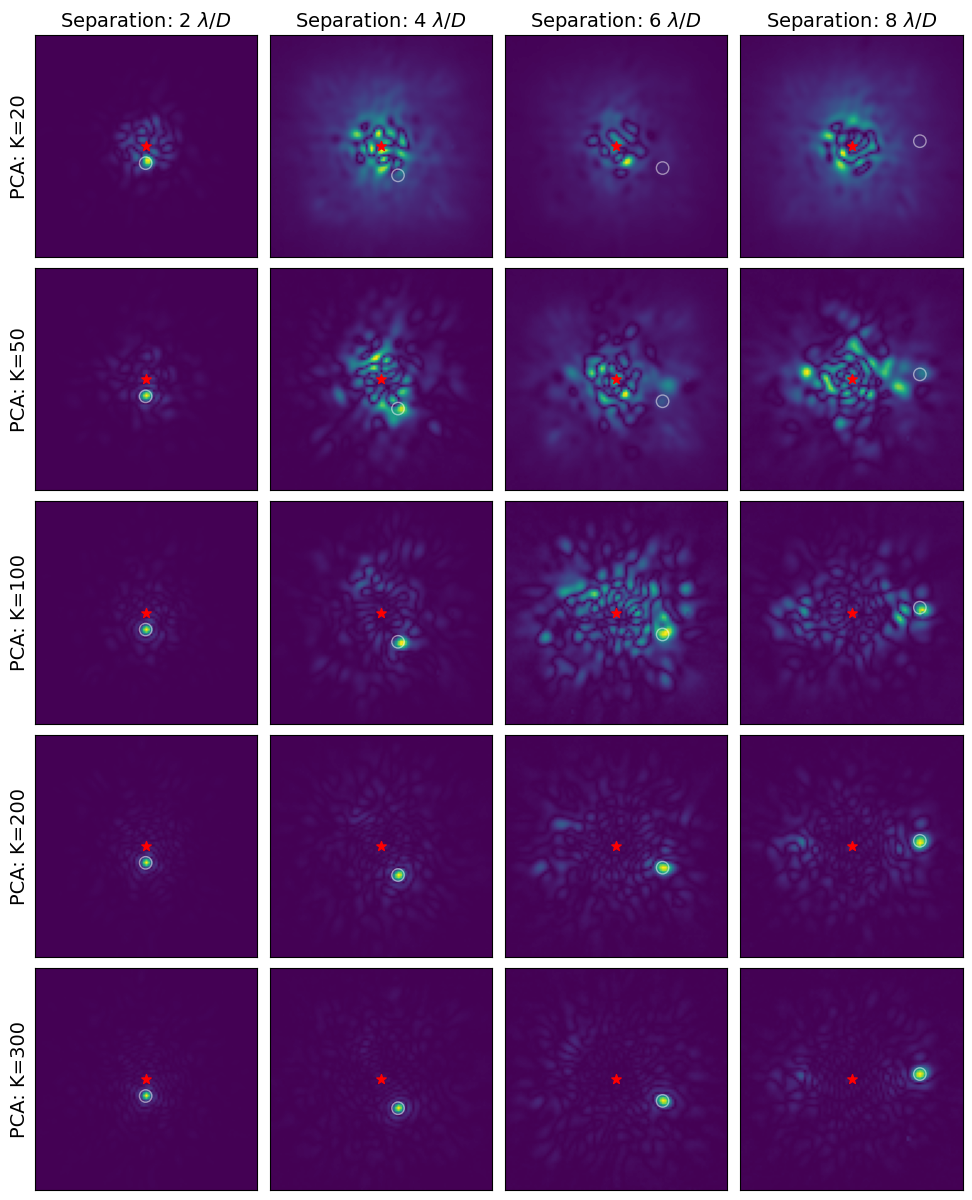

In [27]:
fig = plt.figure(constrained_layout=False, figsize=(12, 15))

gs01 = fig.add_gridspec(
    5, 4, 
    wspace=0.05, hspace=0.05)

# Plot the Saliency Maps
# For each row fix one number of PCA components
# For each column fix one position
for i, pca_number in enumerate(pca_numbers):
    for j in range(4):
        ax = fig.add_subplot(gs01[i, j])
        plot_saliency_map2(ax, input_gradients_dict[pca_number], positions[j])
        ax.set_xticks([])
        ax.set_yticks([])
        add_marker_circle(ax, positions[j], "white")
        
        # add the number of pca components as y-label
        if j == 0:
            ax.set_ylabel(f"PCA: K={pca_number}", fontsize=14)
        
        # add the position as title
        if i == 0:
            ax.set_title(f"Separation: {int(position_separations[j] / 3.6)} $\lambda /D$", fontsize=14)
            
# Add Figure Title
fig.patch.set_facecolor('white')
plt.savefig("./final_plots/0a3_pca_saliency_map.pdf", bbox_inches='tight')

## 6. Plot the trends as a function of separation

In [23]:
from applefy.utils.positions import estimate_noise_positions

In [24]:
def get_matches(pca_number, separations):
    matches = []

    tmp_input_gradients = torch.matmul(V[:, :pca_number], V[:, :pca_number].T)
    tmp_input_gradients = np.abs(tmp_input_gradients.detach().numpy())
    tmp_input_gradients = tmp_input_gradients.reshape(-1, 91, 91)
    
    for tmp_separation in separations:
        positions = np.array(estimate_noise_positions(
            3.6*tmp_separation, 
            (science_data[10].shape[0]/2-1, 
             science_data[10].shape[0]/2-1), 
            3.6/2))[:, :2].astype(int)
        
        indices = positions[:, 0]*91 + positions[:, 1]
        extracted = np.array([tmp_input_gradients[indices][i][
            positions[i, 0]-10:positions[i, 0]+11, 
            positions[i, 1]-10:positions[i, 1]+11] for i in range(len(positions))])
        
        tmp_match = np.mean((extracted*psf_template).sum(axis=(1, 2)))
        matches.append(tmp_match)
        
    return matches

In [25]:
pca_matches = []
pca_number = np.arange(1, 500, 10)

for tmp_pca in tqdm(pca_number):
    tmp_matches = get_matches(tmp_pca, [1.5, 4, 8])
    pca_matches.append(tmp_matches)

pca_matches = np.array(pca_matches)
pca_matches /= np.max(pca_matches)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:23<00:00,  2.12it/s]


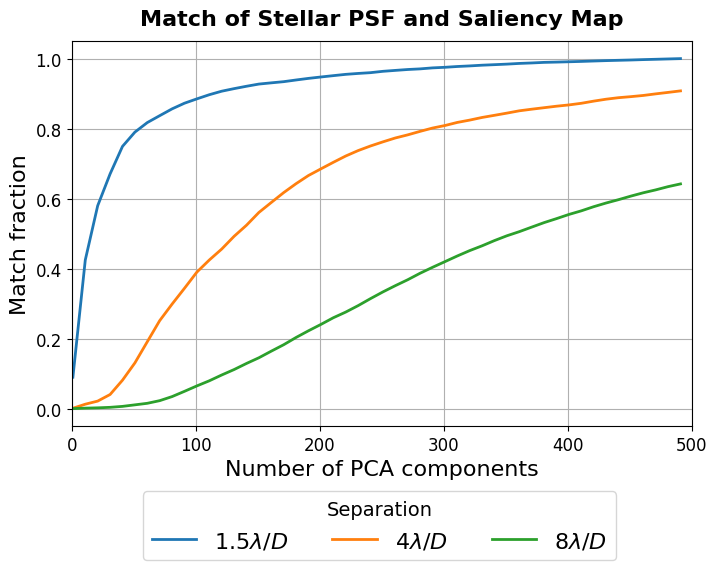

In [26]:
# 1.) Create Plot Layout ------------------------------------------
fig = plt.figure(constrained_layout=False, figsize=(8, 5))
gs0 = fig.add_gridspec(1, 1)

axis_match = fig.add_subplot(gs0[0, 0])

# 2.) Make the plot -----------------------------------------------
axis_match.plot(
    pca_number, pca_matches[:, 0], 
    lw=2, label="$1.5 \lambda /D$")
axis_match.plot(
    pca_number, pca_matches[:, 1], 
    lw=2, label="$4 \lambda /D$")
axis_match.plot(
    pca_number, pca_matches[:, 2], 
    lw=2, label="$8 \lambda /D$")
axis_match.grid()

# 3.) Set limits ---------------------------------------------------
axis_match.set_xlim(0, 500)
axis_match.tick_params(axis='both', which='major', labelsize=12)

# 4.) Set Labels ---------------------------------------------------
axis_match.set_xlabel(r"Number of PCA components", size=16)
axis_match.set_ylabel(r"Match fraction", size=16)

axis_match.set_title(
    r"Match of Stellar PSF and Saliency Map",
    fontsize=16, fontweight="bold", y=1.02)

# 5.) Legend -----------------------------------------------------------
handles, labels = axis_match.get_legend_handles_labels()
leg1 = fig.legend(handles, labels,
                  bbox_to_anchor=(0.20, -0.18),
                  fontsize=16,
                  title="Separation",
                  loc='lower left', ncol=3)
plt.setp(leg1.get_title(),fontsize=14)

# 5.) Save the Plot ----------------------------------------------------
fig.patch.set_facecolor('white')
plt.savefig("./final_plots/03_match_saliency_map.pdf",
            bbox_extra_artists=(leg1,),
            bbox_inches='tight')